In [1]:
#getting and working with data
import pandas as pd
import numpy as np
import re
import os
import datetime as dt
import string

#visualizing results
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context("poster")
sns.set_style("ticks")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 15000)
pd.set_option('display.max_colwidth', -1)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

/Users/abbieschindler/opt/anaconda3/envs/analysis/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


### RFID data

#### Get paths for files to process

In [2]:
#create list of dir paths
RFID_path = '/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID/build_1.0/RFID/koolaid'
    
RFID_file_names = os.listdir(RFID_path)

RFID_data_dir_paths = []

for file in RFID_file_names:
    int_path = RFID_path + '/' + file
    RFID_data_dir_paths.append(int_path)
    
RFID_data_dir_paths

['/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID/build_1.0/RFID/koolaid/Idspyder-21.08.17.csv',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID/build_1.0/RFID/koolaid/Idspyder-21.08.11.csv',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID/build_1.0/RFID/koolaid/Idspyder-21.08.13.csv',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID/build_1.0/RFID/koolaid/Idspyder-21.08.23.csv',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID/build_1.0/RFID/koolaid/Idspyder-21.08.26.csv']

#### Clean df and combine into 1

In [27]:
data_RFID = pd.DataFrame()

for path in RFID_data_dir_paths[4:5]:
    print(path)

    if path.split('/')[-1] == '.DS_Store':
        continue
    
    #data_RFID_int['file'] = path.split('/')[-1]
    
    #create data table
    data_RFID_int = pd.read_csv(path, sep=';', encoding='utf-16')
    data_RFID_int = pd.DataFrame(data = data_RFID_int)
    data_RFID_int = data_RFID_int.drop([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])

    print(data_RFID_int.shape)
    
    #drop rows with no event duration
    data_RFID_int = data_RFID_int[~data_RFID_int['eventDuration'].isna()]
    
    #convert from ms to sec
    data_RFID_int['eventDuration'] = data_RFID_int['eventDuration']/1000
    #clean up and create datetime columns
    data_RFID_int['start_datetime'] = pd.to_datetime(data_RFID_int['DateTime'], unit='d')
    #can't figure out datetime format so hard code for now
    data_RFID_int['RFID_datetime_start'] = [x.replace(year = 2021) - dt.timedelta(days = 2) for x in data_RFID_int['start_datetime']] 
    data_RFID_int['RFID_date'] = data_RFID_int['RFID_datetime_start'].dt.date 
    data_RFID_int['RFID_day'] = data_RFID_int['RFID_datetime_start'].dt.day 
    data_RFID_int['RFID_time_start'] = [x.split(' ')[1] for x in data_RFID_int['RFID_datetime_start'].dt.strftime("%Y-%m-%d %H:%M:%S")]
    data_RFID_int['RFID_hour'] = data_RFID_int['RFID_datetime_start'].dt.hour
    data_RFID_int['RFID_min'] = data_RFID_int['RFID_datetime_start'].dt.minute
    data_RFID_int['RFID_second'] = data_RFID_int['RFID_datetime_start'].dt.second

    if data_RFID.empty:
        data_RFID = data_RFID_int
    else:
        data_RFID = pd.concat([data_RFID, data_RFID_int], axis=0)
        
    print(data_RFID.shape,'\n')

#clean columns
data_RFID = data_RFID[['IdRFID', 'unitLabel', 'eventDuration',
       'RFID_datetime_start', 'RFID_date',
       'RFID_day', 'RFID_time_start', 'RFID_hour', 'RFID_min', 'RFID_second']]
    
data_RFID.head()

/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID/build_1.0/RFID/koolaid/Idspyder-21.08.26.csv
(14177, 14)
(14176, 22) 



,IdRFID,unitLabel,eventDuration,RFID_datetime_start,RFID_date,RFID_day,RFID_time_start,RFID_hour,RFID_min,RFID_second
17,041A5554CE,AM1-6,2.503,2021-08-26 11:56:36.705033600,2021-08-26,26,11:56:36,11,56,36
18,041A555AB5,AM1-6,0.075,2021-08-26 11:57:02.421993600,2021-08-26,26,11:57:02,11,57,2
19,041A555AB5,AM1-6,0.729,2021-08-26 11:57:03.435984000,2021-08-26,26,11:57:03,11,57,3
20,041A555C9D,AM1-6,1.800,2021-08-26 11:57:35.779046400,2021-08-26,26,11:57:35,11,57,35
21,041A555AB5,AM1-1,3.778,2021-08-26 11:57:35.590953600,2021-08-26,26,11:57:35,11,57,35


#### Compute endtime 

In [28]:
#compute end time for each eventDuration
def add_duration(a, b):
    newtime = a + dt.timedelta(0, b)

    return newtime

data_RFID['RFID_datetime_end'] = data_RFID.apply(lambda row: add_duration(row['RFID_datetime_start'], row['eventDuration']), axis=1)
data_RFID['RFID_time_end'] = [x.split(' ')[1] for x in data_RFID['RFID_datetime_end'].dt.strftime("%Y-%m-%d %H:%M:%S")]

print(data_RFID.shape)
data_RFID.head()

(14176, 12)


,IdRFID,unitLabel,eventDuration,RFID_datetime_start,RFID_date,RFID_day,RFID_time_start,RFID_hour,RFID_min,RFID_second,RFID_datetime_end,RFID_time_end
17,041A5554CE,AM1-6,2.503,2021-08-26 11:56:36.705033600,2021-08-26,26,11:56:36,11,56,36,2021-08-26 11:56:39.208033600,11:56:39
18,041A555AB5,AM1-6,0.075,2021-08-26 11:57:02.421993600,2021-08-26,26,11:57:02,11,57,2,2021-08-26 11:57:02.496993600,11:57:02
19,041A555AB5,AM1-6,0.729,2021-08-26 11:57:03.435984000,2021-08-26,26,11:57:03,11,57,3,2021-08-26 11:57:04.164984000,11:57:04
20,041A555C9D,AM1-6,1.800,2021-08-26 11:57:35.779046400,2021-08-26,26,11:57:35,11,57,35,2021-08-26 11:57:37.579046400,11:57:37
21,041A555AB5,AM1-1,3.778,2021-08-26 11:57:35.590953600,2021-08-26,26,11:57:35,11,57,35,2021-08-26 11:57:39.368953600,11:57:39


#### Add next column (do for each unitLabel separately)

In [29]:
#column for if next is same Id
def next_compare(a, b):
    if a == b:
        compare = 'same'
        
    if a != b:
        compare = 'diff'

    return compare

data_RFID_next = pd.DataFrame()

for unitlabel in data_RFID['unitLabel'].unique():
    print(unitlabel)

    data_int = data_RFID[data_RFID['unitLabel'] == unitlabel].sort_values(['RFID_datetime_start'])
    data_int['RFID_datetime_start_next'] = data_int['RFID_datetime_start'].shift(-1)
    data_int['IdRFID_next'] = data_int['IdRFID'].shift(-1)
    
    data_int['IdRFID_diff_next'] = data_int.apply(lambda row: next_compare(row['IdRFID'], row['IdRFID_next']), axis=1)

    if data_RFID_next.empty:
        data_RFID_next = data_int
    else:
        data_RFID_next = pd.concat([data_RFID_next, data_int], axis=0)

data_RFID_next['time_diff_next'] = (data_RFID_next['RFID_datetime_start_next'] - data_RFID_next['RFID_datetime_end'])
data_RFID_next['time_diff_next'] = [x.total_seconds() for x in data_RFID_next['time_diff_next']]
data_RFID_next['time_diff_next_round'] = data_RFID_next['time_diff_next'].round(-1)
data_RFID_next.head()

AM1-6
AM1-1
AM1-4
AM1-2
AM1-3


,IdRFID,unitLabel,eventDuration,RFID_datetime_start,RFID_date,RFID_day,RFID_time_start,RFID_hour,RFID_min,RFID_second,RFID_datetime_end,RFID_time_end,RFID_datetime_start_next,IdRFID_next,IdRFID_diff_next,time_diff_next,time_diff_next_round
17,041A5554CE,AM1-6,2.503,2021-08-26 11:56:36.705033600,2021-08-26,26,11:56:36,11,56,36,2021-08-26 11:56:39.208033600,11:56:39,2021-08-26 11:57:02.421993600,041A555AB5,diff,23.213960,20.0
18,041A555AB5,AM1-6,0.075,2021-08-26 11:57:02.421993600,2021-08-26,26,11:57:02,11,57,2,2021-08-26 11:57:02.496993600,11:57:02,2021-08-26 11:57:03.435984000,041A555AB5,same,0.938990,0.0
19,041A555AB5,AM1-6,0.729,2021-08-26 11:57:03.435984000,2021-08-26,26,11:57:03,11,57,3,2021-08-26 11:57:04.164984000,11:57:04,2021-08-26 11:57:35.779046400,041A555C9D,diff,31.614062,30.0
20,041A555C9D,AM1-6,1.800,2021-08-26 11:57:35.779046400,2021-08-26,26,11:57:35,11,57,35,2021-08-26 11:57:37.579046400,11:57:37,NaT,NaN,diff,NaN,NaN
21,041A555AB5,AM1-1,3.778,2021-08-26 11:57:35.590953600,2021-08-26,26,11:57:35,11,57,35,2021-08-26 11:57:39.368953600,11:57:39,2021-08-26 11:57:49.682966400,041A5554CE,diff,10.314012,10.0


#### Add day, hour, and min counts

In [30]:
#column of running day count
dat_map = dict(zip(data_RFID_next['RFID_date'].unique(), np.arange(1,len(data_RFID_next['RFID_date'].unique())+1)))
data_RFID_next['RFID_day_count'] = data_RFID_next['RFID_date'].map(dat_map)

#column of running min and second count within each day
data_RFID_next['RFID_min_count'] = (data_RFID_next['RFID_hour']*60) + data_RFID_next['RFID_min'] 
data_RFID_next['RFID_sec_count'] = (data_RFID_next['RFID_min_count']*60) + data_RFID_next['RFID_second'] 

#column of running hour and minute count across all days
data_RFID_next['RFID_hour_count_running'] = (data_RFID_next['RFID_day_count']*24) + data_RFID_next['RFID_hour'] - 24
data_RFID_next['RFID_min_count_running'] = (data_RFID_next['RFID_hour_count_running']*60) + data_RFID_next['RFID_min'] 
data_RFID_next['RFID_sec_count_running'] = (data_RFID_next['RFID_min_count_running']*60) + data_RFID_next['RFID_second'] - 60

print(data_RFID_next.shape)
data_RFID_next.head()

(14176, 23)


,IdRFID,unitLabel,eventDuration,RFID_datetime_start,RFID_date,RFID_day,RFID_time_start,RFID_hour,RFID_min,RFID_second,RFID_datetime_end,RFID_time_end,RFID_datetime_start_next,IdRFID_next,IdRFID_diff_next,time_diff_next,time_diff_next_round,RFID_day_count,RFID_min_count,RFID_sec_count,RFID_hour_count_running,RFID_min_count_running,RFID_sec_count_running
17,041A5554CE,AM1-6,2.503,2021-08-26 11:56:36.705033600,2021-08-26,26,11:56:36,11,56,36,2021-08-26 11:56:39.208033600,11:56:39,2021-08-26 11:57:02.421993600,041A555AB5,diff,23.213960,20.0,1,716,42996,11,716,42936
18,041A555AB5,AM1-6,0.075,2021-08-26 11:57:02.421993600,2021-08-26,26,11:57:02,11,57,2,2021-08-26 11:57:02.496993600,11:57:02,2021-08-26 11:57:03.435984000,041A555AB5,same,0.938990,0.0,1,717,43022,11,717,42962
19,041A555AB5,AM1-6,0.729,2021-08-26 11:57:03.435984000,2021-08-26,26,11:57:03,11,57,3,2021-08-26 11:57:04.164984000,11:57:04,2021-08-26 11:57:35.779046400,041A555C9D,diff,31.614062,30.0,1,717,43023,11,717,42963
20,041A555C9D,AM1-6,1.800,2021-08-26 11:57:35.779046400,2021-08-26,26,11:57:35,11,57,35,2021-08-26 11:57:37.579046400,11:57:37,NaT,NaN,diff,NaN,NaN,1,717,43055,11,717,42995
21,041A555AB5,AM1-1,3.778,2021-08-26 11:57:35.590953600,2021-08-26,26,11:57:35,11,57,35,2021-08-26 11:57:39.368953600,11:57:39,2021-08-26 11:57:49.682966400,041A5554CE,diff,10.314012,10.0,1,717,43055,11,717,42995


#### Add light dark

In [31]:
def assign_ld(time):
    if (time >= 6) & (time < 18):
        return 'light'
    if (time >= 0) & (time < 6):
        return 'dark_am'
    if (time >= 18):
        return 'dark_pm'
    
data_RFID_next['ld_seg'] = data_RFID_next['RFID_hour'].apply(assign_ld)

print(data_RFID_next.shape)
data_RFID_next.head()


(14176, 24)


,IdRFID,unitLabel,eventDuration,RFID_datetime_start,RFID_date,RFID_day,RFID_time_start,RFID_hour,RFID_min,RFID_second,RFID_datetime_end,RFID_time_end,RFID_datetime_start_next,IdRFID_next,IdRFID_diff_next,time_diff_next,time_diff_next_round,RFID_day_count,RFID_min_count,RFID_sec_count,RFID_hour_count_running,RFID_min_count_running,RFID_sec_count_running,ld_seg
17,041A5554CE,AM1-6,2.503,2021-08-26 11:56:36.705033600,2021-08-26,26,11:56:36,11,56,36,2021-08-26 11:56:39.208033600,11:56:39,2021-08-26 11:57:02.421993600,041A555AB5,diff,23.213960,20.0,1,716,42996,11,716,42936,light
18,041A555AB5,AM1-6,0.075,2021-08-26 11:57:02.421993600,2021-08-26,26,11:57:02,11,57,2,2021-08-26 11:57:02.496993600,11:57:02,2021-08-26 11:57:03.435984000,041A555AB5,same,0.938990,0.0,1,717,43022,11,717,42962,light
19,041A555AB5,AM1-6,0.729,2021-08-26 11:57:03.435984000,2021-08-26,26,11:57:03,11,57,3,2021-08-26 11:57:04.164984000,11:57:04,2021-08-26 11:57:35.779046400,041A555C9D,diff,31.614062,30.0,1,717,43023,11,717,42963,light
20,041A555C9D,AM1-6,1.800,2021-08-26 11:57:35.779046400,2021-08-26,26,11:57:35,11,57,35,2021-08-26 11:57:37.579046400,11:57:37,NaT,NaN,diff,NaN,NaN,1,717,43055,11,717,42995,light
21,041A555AB5,AM1-1,3.778,2021-08-26 11:57:35.590953600,2021-08-26,26,11:57:35,11,57,35,2021-08-26 11:57:39.368953600,11:57:39,2021-08-26 11:57:49.682966400,041A5554CE,diff,10.314012,10.0,1,717,43055,11,717,42995,light


#### Add day/night mapping (lines up dates and ld segments)

In [32]:
ld_mapping_path = '/Users/abbieschindler/Documents/ProgrammingFun/iPythonScripts/ld_mapping.xlsx'

ld_mapping = pd.read_excel(ld_mapping_path)
ld_mapping = pd.DataFrame(data = ld_mapping)
print(ld_mapping.shape)
ld_mapping.head()

(89, 3)


,day,ld_seg,ld
0,2,dark_am,dark_night1
1,3,dark_am,dark_night2
2,4,dark_am,dark_night3
3,5,dark_am,dark_night4
4,6,dark_am,dark_night5


In [33]:
data_RFID_next = data_RFID_next.merge(ld_mapping, right_on=['day', 'ld_seg'], left_on=['RFID_day_count', 'ld_seg'])
print(data_RFID_next.shape)
data_RFID_next.head()

(14176, 26)


,IdRFID,unitLabel,eventDuration,RFID_datetime_start,RFID_date,RFID_day,RFID_time_start,RFID_hour,RFID_min,RFID_second,RFID_datetime_end,RFID_time_end,RFID_datetime_start_next,IdRFID_next,IdRFID_diff_next,time_diff_next,time_diff_next_round,RFID_day_count,RFID_min_count,RFID_sec_count,RFID_hour_count_running,RFID_min_count_running,RFID_sec_count_running,ld_seg,day,ld
0,041A5554CE,AM1-6,2.503,2021-08-26 11:56:36.705033600,2021-08-26,26,11:56:36,11,56,36,2021-08-26 11:56:39.208033600,11:56:39,2021-08-26 11:57:02.421993600,041A555AB5,diff,23.213960,20.0,1,716,42996,11,716,42936,light,1,light_day1
1,041A555AB5,AM1-6,0.075,2021-08-26 11:57:02.421993600,2021-08-26,26,11:57:02,11,57,2,2021-08-26 11:57:02.496993600,11:57:02,2021-08-26 11:57:03.435984000,041A555AB5,same,0.938990,0.0,1,717,43022,11,717,42962,light,1,light_day1
2,041A555AB5,AM1-6,0.729,2021-08-26 11:57:03.435984000,2021-08-26,26,11:57:03,11,57,3,2021-08-26 11:57:04.164984000,11:57:04,2021-08-26 11:57:35.779046400,041A555C9D,diff,31.614062,30.0,1,717,43023,11,717,42963,light,1,light_day1
3,041A555C9D,AM1-6,1.800,2021-08-26 11:57:35.779046400,2021-08-26,26,11:57:35,11,57,35,2021-08-26 11:57:37.579046400,11:57:37,NaT,NaN,diff,NaN,NaN,1,717,43055,11,717,42995,light,1,light_day1
4,041A555AB5,AM1-1,3.778,2021-08-26 11:57:35.590953600,2021-08-26,26,11:57:35,11,57,35,2021-08-26 11:57:39.368953600,11:57:39,2021-08-26 11:57:49.682966400,041A5554CE,diff,10.314012,10.0,1,717,43055,11,717,42995,light,1,light_day1


#### Map unitLabel and bottle contents

In [34]:


unitLabel_map = {'AM1-1': 'cherry',
                 'AM1-2': 'orange',
                 'AM1-3': 'raspberry',
                 'AM1-4': 'grape',
                 'AM1-5': 'cherry',
                 'AM1-6': 'orange',
                 'AM1-7': 'raspberry',
                 'AM1-8': 'grape',
                 'AM1-9': 'cherry',
                 'AM1-10': 'orange',
                 'AM1-11': 'raspberry',
                 'AM1-12': 'grape',
                 'AM1-13': 'cherry',
                 'AM1-14': 'orange',
                 'AM1-15': 'raspberry',
                 'AM1-16': 'grape',}

unitLabel_map = {'AM1-1': 'plain',
                 'AM1-2': 'etoh20',
                 'AM1-3': 'etoh10',
                 'AM1-4': 'etoh05',
                 'AM1-5': 'plain',
                 'AM1-6': 'etoh20',
                 'AM1-7': 'etoh10',
                 'AM1-8': 'etoh05',
                 'AM1-9': 'plain',
                 'AM1-10': 'etoh20',
                 'AM1-11': 'etoh10',
                 'AM1-12': 'etoh05',
                 'AM1-13': 'plain',
                 'AM1-14': 'etoh20',
                 'AM1-15': 'etoh10',
                 'AM1-16': 'etoh05',}

unitLabel_map = {'AM1-1': 'plain',
                 'AM1-2': 'etoh05',
                 'AM1-3': 'etoh10',
                 'AM1-4': 'etoh20',
                 'AM1-5': 'plain',
                 'AM1-6': 'etoh05',
                 'AM1-7': 'etoh10',
                 'AM1-8': 'etoh20',
                 'AM1-9': 'plain',
                 'AM1-10': 'etoh05',
                 'AM1-11': 'etoh10',
                 'AM1-12': 'etoh20',
                 'AM1-13': 'plain',
                 'AM1-14': 'etoh05',
                 'AM1-15': 'etoh10',
                 'AM1-16': 'etoh20',}

data_RFID_next['unitLabel_drink'] = data_RFID_next['unitLabel'].map(unitLabel_map)
print(data_RFID_next.shape)

(14176, 27)


#### Add metadata and clean

In [35]:
meta_path = '/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID/meta/meta_data_1.0.xlsx'
meta_data = pd.read_excel(meta_path)
meta_data = pd.DataFrame(data = meta_data)

data_RFID_final = meta_data.merge(data_RFID_next.reset_index(), on='IdRFID', sort=False)

print(data_RFID_final.shape)
data_RFID_final.head()

(14176, 44)


,Round,Round_info,Sub_round,Timepoint,Cage_N,Cage,Animal,Injury,Sex,IdRFID,weight_pre,weight_post,weight_diff,notes,wes_day,wd_day,r_day,index,unitLabel,eventDuration,RFID_datetime_start,RFID_date,RFID_day,RFID_time_start,RFID_hour,RFID_min,RFID_second,RFID_datetime_end,RFID_time_end,RFID_datetime_start_next,IdRFID_next,IdRFID_diff_next,time_diff_next,time_diff_next_round,RFID_day_count,RFID_min_count,RFID_sec_count,RFID_hour_count_running,RFID_min_count_running,RFID_sec_count_running,ld_seg,day,ld,unitLabel_drink
0,KA1,intruders,2,NaN,3,1,NaN,NaN,m,041A5554CE,27.8,NaN,NaN,NaN,NaN,NaN,NaN,0,AM1-6,2.503,2021-08-26 11:56:36.705033600,2021-08-26,26,11:56:36,11,56,36,2021-08-26 11:56:39.208033600,11:56:39,2021-08-26 11:57:02.421993600,041A555AB5,diff,23.213960,20.0,1,716,42996,11,716,42936,light,1,light_day1,etoh05
1,KA1,intruders,2,NaN,3,1,NaN,NaN,m,041A5554CE,27.8,NaN,NaN,NaN,NaN,NaN,NaN,5,AM1-1,1.873,2021-08-26 11:57:49.682966400,2021-08-26,26,11:57:49,11,57,49,2021-08-26 11:57:51.555966400,11:57:51,2021-08-26 11:57:53.070969600,041A5554CE,same,1.515003,0.0,1,717,43069,11,717,43009,light,1,light_day1,plain
2,KA1,intruders,2,NaN,3,1,NaN,NaN,m,041A5554CE,27.8,NaN,NaN,NaN,NaN,NaN,NaN,6,AM1-1,0.594,2021-08-26 11:57:53.070969600,2021-08-26,26,11:57:53,11,57,53,2021-08-26 11:57:53.664969600,11:57:53,2021-08-26 12:00:54.654998400,041A555AB5,diff,180.990028,180.0,1,717,43073,11,717,43013,light,1,light_day1,plain
3,KA1,intruders,2,NaN,3,1,NaN,NaN,m,041A5554CE,27.8,NaN,NaN,NaN,NaN,NaN,NaN,9,AM1-1,5.535,2021-08-26 12:02:53.684995200,2021-08-26,26,12:02:53,12,2,53,2021-08-26 12:02:59.219995200,12:02:59,2021-08-26 12:04:21.133027200,041A555C9D,diff,81.913032,80.0,1,722,43373,12,722,43313,light,1,light_day1,plain
4,KA1,intruders,2,NaN,3,1,NaN,NaN,m,041A5554CE,27.8,NaN,NaN,NaN,NaN,NaN,NaN,20,AM1-1,2.332,2021-08-26 12:08:43.575014400,2021-08-26,26,12:08:43,12,8,43,2021-08-26 12:08:45.907014400,12:08:45,2021-08-26 12:08:47.627001600,041A5554CE,same,1.719987,0.0,1,728,43723,12,728,43663,light,1,light_day1,plain


In [36]:
data_RFID_final = data_RFID_final[['Round', 'Round_info', 'Timepoint', 'Cage_N', 'Cage', 'Animal',
                                   'Injury', 'Sex', 'IdRFID', 'weight_pre', 'weight_post', 'weight_diff', 
                                   'notes', 
                                   'unitLabel', 'unitLabel_drink', 'eventDuration',
                                   'RFID_datetime_start', 'RFID_datetime_end',
                                   'RFID_datetime_start_next', 'IdRFID_next', 
                                   'IdRFID_diff_next', 'time_diff_next', 'time_diff_next_round', 
                                   'RFID_time_start', 'RFID_time_end',
                                   'RFID_date', 'RFID_day', 'ld', 'ld_seg', 'RFID_day_count',
                                   'RFID_hour', 'RFID_min', 'RFID_second',
                                   'RFID_min_count', 'RFID_sec_count',
                                   'RFID_hour_count_running', 'RFID_min_count_running', 'RFID_sec_count_running']]

print(data_RFID_final.shape)
data_RFID_final.head()

(14176, 38)


,Round,Round_info,Timepoint,Cage_N,Cage,Animal,Injury,Sex,IdRFID,weight_pre,weight_post,weight_diff,notes,unitLabel,unitLabel_drink,eventDuration,RFID_datetime_start,RFID_datetime_end,RFID_datetime_start_next,IdRFID_next,IdRFID_diff_next,time_diff_next,time_diff_next_round,RFID_time_start,RFID_time_end,RFID_date,RFID_day,ld,ld_seg,RFID_day_count,RFID_hour,RFID_min,RFID_second,RFID_min_count,RFID_sec_count,RFID_hour_count_running,RFID_min_count_running,RFID_sec_count_running
0,KA1,intruders,NaN,3,1,NaN,NaN,m,041A5554CE,27.8,NaN,NaN,NaN,AM1-6,etoh05,2.503,2021-08-26 11:56:36.705033600,2021-08-26 11:56:39.208033600,2021-08-26 11:57:02.421993600,041A555AB5,diff,23.213960,20.0,11:56:36,11:56:39,2021-08-26,26,light_day1,light,1,11,56,36,716,42996,11,716,42936
1,KA1,intruders,NaN,3,1,NaN,NaN,m,041A5554CE,27.8,NaN,NaN,NaN,AM1-1,plain,1.873,2021-08-26 11:57:49.682966400,2021-08-26 11:57:51.555966400,2021-08-26 11:57:53.070969600,041A5554CE,same,1.515003,0.0,11:57:49,11:57:51,2021-08-26,26,light_day1,light,1,11,57,49,717,43069,11,717,43009
2,KA1,intruders,NaN,3,1,NaN,NaN,m,041A5554CE,27.8,NaN,NaN,NaN,AM1-1,plain,0.594,2021-08-26 11:57:53.070969600,2021-08-26 11:57:53.664969600,2021-08-26 12:00:54.654998400,041A555AB5,diff,180.990028,180.0,11:57:53,11:57:53,2021-08-26,26,light_day1,light,1,11,57,53,717,43073,11,717,43013
3,KA1,intruders,NaN,3,1,NaN,NaN,m,041A5554CE,27.8,NaN,NaN,NaN,AM1-1,plain,5.535,2021-08-26 12:02:53.684995200,2021-08-26 12:02:59.219995200,2021-08-26 12:04:21.133027200,041A555C9D,diff,81.913032,80.0,12:02:53,12:02:59,2021-08-26,26,light_day1,light,1,12,2,53,722,43373,12,722,43313
4,KA1,intruders,NaN,3,1,NaN,NaN,m,041A5554CE,27.8,NaN,NaN,NaN,AM1-1,plain,2.332,2021-08-26 12:08:43.575014400,2021-08-26 12:08:45.907014400,2021-08-26 12:08:47.627001600,041A5554CE,same,1.719987,0.0,12:08:43,12:08:45,2021-08-26,26,light_day1,light,1,12,8,43,728,43723,12,728,43663


#### Viz

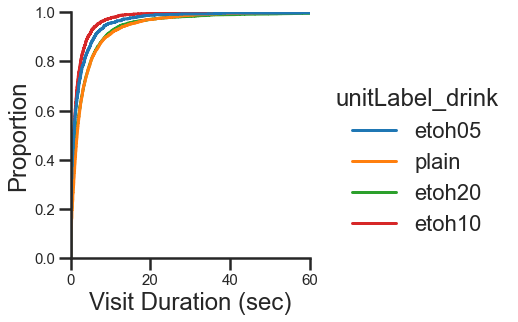

In [37]:
data_int = data_RFID_final[data_RFID_final['eventDuration'] > 1]
sns.displot(data=data_RFID_final, x="eventDuration", kind="ecdf", hue='unitLabel_drink')
plt.xlabel('Visit Duration (sec)')
plt.xlim(0, 60)
plt.show()

<Figure size 720x360 with 0 Axes>

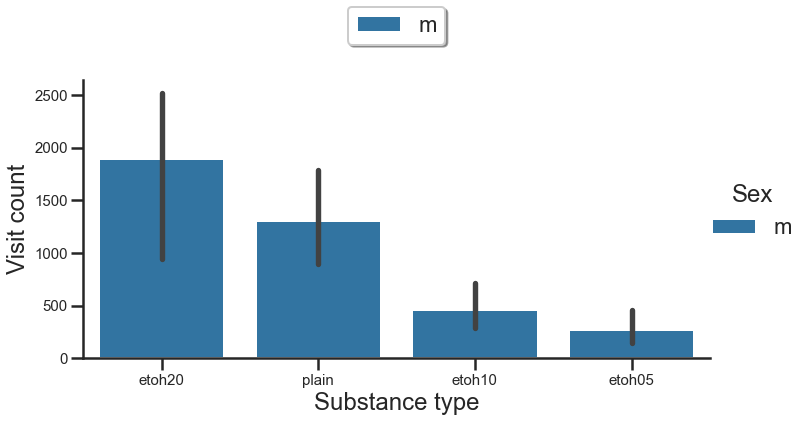

In [38]:
data_int = data_RFID_final[data_RFID_final['eventDuration']>0.2]

data_int = data_int.groupby(['IdRFID', 'Sex', 'Cage'])['unitLabel_drink'].value_counts().reset_index(name='count')

plt.figure(figsize=(10,5))
params = {'axes.labelsize': 30,
          'axes.titlesize': 30}
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
sns.catplot(data=data_int, x="unitLabel_drink", y='count', hue="Sex", kind='bar', height=5, aspect=2,)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3),
          ncol=5, fancybox=True, shadow=True)
plt.xlabel('Substance type')
plt.ylabel('Visit count')
plt.show()

### VDM data

#### Make and clean df

In [39]:
#create list of dir paths
VDM_path = '/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID/build_1.0/VDM/koolaid'
    
VDM_file_names = os.listdir(VDM_path)

VDM_data_dir_paths = []

for file in VDM_file_names:
    int_path = VDM_path + '/' + file
    VDM_data_dir_paths.append(int_path)
    
VDM_data_dir_paths

['/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID/build_1.0/VDM/koolaid/p.05.10.20_mfc2_210823.csv',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID/build_1.0/VDM/koolaid/p.20.10.05_mfc2_210817.csv',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID/build_1.0/VDM/koolaid/p.05.10.20_mc3_210826.csv',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID/build_1.0/VDM/koolaid/c.o.br.g_mfc2_210811.csv',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID/build_1.0/VDM/koolaid/g.go.o.w_mfc2_210813.csv']

In [40]:
data_VDM = pd.DataFrame()

for path in VDM_data_dir_paths[2:3]:
    print(path)
    
    if path.split('/')[-1] == '.DS_Store':
        continue
        
    #create data table
    data_VDM_int = pd.read_table(path, sep=';')
    data_VDM_int = pd.DataFrame(data = data_VDM_int)
    data_VDM_int = data_VDM_int.drop([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17])['Columbus Instruments Device Interface Version 1.5'].str.split(',', expand=True)
    data_VDM_int.columns = data_VDM_int.loc[18].values
    data_VDM_int = data_VDM_int.drop([18])
    
    data_VDM_int['Cohort'] = path.split('/')[-1].split('_')[1]
    data_VDM_int['TP'] = path.split('/')[-1].split('_')[0]
    data_VDM_int['StartDate'] = path.split('/')[-1].split('_')[2]

    if data_VDM.empty:
        data_VDM = data_VDM_int
    else:
        data_VDM = pd.concat([data_VDM, data_VDM_int], axis=0)
        
    print(data_VDM.shape,'\n')

print(data_VDM.shape)
data_VDM.head()

/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID/build_1.0/VDM/koolaid/p.05.10.20_mc3_210826.csv
(1095257, 15) 

(1095257, 15)


,Int,Cage,Time,Drinking (ml),Drinking Accum (ml),Drinking (ml),Drinking Accum (ml),Drinking (ml),Drinking Accum (ml),Drinking (ml),Drinking Accum (ml),,Cohort,TP,StartDate
19,0,1,08/26/21 12:00:59,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,,mc3,p.05.10.20,210826.csv
20,0,2,08/26/21 12:00:59,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,,mc3,p.05.10.20,210826.csv
21,0,3,08/26/21 12:00:59,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,,mc3,p.05.10.20,210826.csv
22,0,4,08/26/21 12:00:59,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,,mc3,p.05.10.20,210826.csv
23,1,1,08/26/21 12:01:00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,,mc3,p.05.10.20,210826.csv


#### Clean up column names

In [ ]:
data_VDM.columns = ['Int', 'Cage_VDM', 'VDM_Time', 
                    'VDM_cherry', 'VDM_cherry_accum',
                    'VDM_orange', 'VDM_orange_accum', 
                    'VDM_raspberry', 'VDM_raspberry_accum',
                    'VDM_grape', 'VDM_grape_accum', '',
                    'Cohort', 'TP', 'StartDate']

data_VDM = data_VDM[['Cage_VDM', 'Cohort', 'TP', 'StartDate', 'VDM_Time', 
                     'VDM_cherry', 'VDM_orange', 'VDM_raspberry', 'VDM_grape']]

data_VDM.tail()

In [41]:
data_VDM.columns = ['Int', 'Cage_VDM', 'VDM_Time', 
                    'VDM_H20', 'VDM_cherry_accum',
                    'VDM_EtOH05', 'VDM_orange_accum', 
                    'VDM_EtOH10', 'VDM_raspberry_accum',
                    'VDM_EtOH20', 'VDM_grape_accum', '',
                    'Cohort', 'TP', 'StartDate']

data_VDM = data_VDM[['Cage_VDM', 'Cohort', 'TP', 'StartDate', 'VDM_Time', 
                     'VDM_H20', 'VDM_EtOH05', 'VDM_EtOH10', 'VDM_EtOH20']]

data_VDM.tail()

,Cage_VDM,Cohort,TP,StartDate,VDM_Time,VDM_H20,VDM_EtOH05,VDM_EtOH10,VDM_EtOH20
1095271,4,mc3,p.05.10.20,210826.csv,08/31/21 13:07:03,0.000,0.000,0.000,0.000
1095272,1,mc3,p.05.10.20,210826.csv,08/31/21 13:07:04,0.000,0.000,0.000,0.000
1095273,2,mc3,p.05.10.20,210826.csv,08/31/21 13:07:04,0.000,0.000,0.000,0.000
1095274,3,mc3,p.05.10.20,210826.csv,08/31/21 13:07:04,0.000,0.000,0.000,0.000
1095275,4,mc3,p.05.10.20,210826.csv,08/31/21 13:07:04,0.000,0.000,0.000,0.000


#### Convert liquid vol to etoh vol

In [ ]:
data_VDM['VDM_cherry'] = data_VDM['VDM_cherry'].astype('float')
data_VDM['VDM_orange'] = data_VDM['VDM_orange'].astype('float')
data_VDM['VDM_raspberry'] = data_VDM['VDM_raspberry'].astype('float')
data_VDM['VDM_grape'] = data_VDM['VDM_grape'].astype('float')

In [42]:
data_VDM['VDM_H20'] = data_VDM['VDM_H20'].astype('float')
data_VDM['VDM_EtOH20'] = data_VDM['VDM_EtOH20'].astype('float')
data_VDM['VDM_EtOH10'] = data_VDM['VDM_EtOH10'].astype('float')
data_VDM['VDM_EtOH05'] = data_VDM['VDM_EtOH05'].astype('float')

#### Make into tidy df

In [43]:
#melt dataframe (new column of parameters)

meta_params = ['Cage_VDM', 'Cohort', 'TP', 'StartDate', 'VDM_Time']
intake_params = ['VDM_H20', 'VDM_EtOH05', 'VDM_EtOH10', 'VDM_EtOH20']

data_VDM_tidy = pd.melt(data_VDM, id_vars=meta_params, value_vars=intake_params)

print(data_VDM_tidy.shape)
data_VDM_tidy.head()

(4381028, 7)


,Cage_VDM,Cohort,TP,StartDate,VDM_Time,variable,value
0,1,mc3,p.05.10.20,210826.csv,08/26/21 12:00:59,VDM_H20,0.0
1,2,mc3,p.05.10.20,210826.csv,08/26/21 12:00:59,VDM_H20,0.0
2,3,mc3,p.05.10.20,210826.csv,08/26/21 12:00:59,VDM_H20,0.0
3,4,mc3,p.05.10.20,210826.csv,08/26/21 12:00:59,VDM_H20,0.0
4,1,mc3,p.05.10.20,210826.csv,08/26/21 12:01:00,VDM_H20,0.0


#### Drop times with no intake data

In [44]:
data_VDM_tidy_intake = data_VDM_tidy[data_VDM_tidy['value'] > 0]
print(data_VDM_tidy_intake.shape)
data_VDM_tidy_intake.head()

(1291, 7)


,Cage_VDM,Cohort,TP,StartDate,VDM_Time,variable,value
26564,1,mc3,p.05.10.20,210826.csv,08/26/21 14:57:11,VDM_H20,0.022
53284,1,mc3,p.05.10.20,210826.csv,08/26/21 17:54:25,VDM_H20,0.022
72680,1,mc3,p.05.10.20,210826.csv,08/26/21 20:03:05,VDM_H20,0.022
77892,1,mc3,p.05.10.20,210826.csv,08/26/21 20:37:39,VDM_H20,0.022
77964,1,mc3,p.05.10.20,210826.csv,08/26/21 20:38:08,VDM_H20,0.022


#### Clean up datetime

In [45]:
#clean up and create datetime columns
data_VDM_tidy_intake['VDM_datetime'] = pd.to_datetime(data_VDM_tidy_intake['VDM_Time'])
data_VDM_tidy_intake['VDM_timestamp'] = [x.timestamp() for x in data_VDM_tidy_intake['VDM_datetime']]

data_VDM_tidy_intake['VDM_date'] = data_VDM_tidy_intake['VDM_datetime'].dt.date
data_VDM_tidy_intake['VDM_day'] = data_VDM_tidy_intake['VDM_datetime'].dt.day
data_VDM_tidy_intake['VDM_time'] = data_VDM_tidy_intake['VDM_datetime'].dt.strftime("%H:%M:%S")
data_VDM_tidy_intake['VDM_hour'] = data_VDM_tidy_intake['VDM_datetime'].dt.hour
data_VDM_tidy_intake['VDM_min'] = data_VDM_tidy_intake['VDM_datetime'].dt.minute
data_VDM_tidy_intake['VDM_second'] = data_VDM_tidy_intake['VDM_datetime'].dt.second

print(data_VDM_tidy_intake.shape)
data_VDM_tidy_intake.head()

(1291, 15)


,Cage_VDM,Cohort,TP,StartDate,VDM_Time,variable,value,VDM_datetime,VDM_timestamp,VDM_date,VDM_day,VDM_time,VDM_hour,VDM_min,VDM_second
26564,1,mc3,p.05.10.20,210826.csv,08/26/21 14:57:11,VDM_H20,0.022,2021-08-26 14:57:11,1.629990e+09,2021-08-26,26,14:57:11,14,57,11
53284,1,mc3,p.05.10.20,210826.csv,08/26/21 17:54:25,VDM_H20,0.022,2021-08-26 17:54:25,1.630000e+09,2021-08-26,26,17:54:25,17,54,25
72680,1,mc3,p.05.10.20,210826.csv,08/26/21 20:03:05,VDM_H20,0.022,2021-08-26 20:03:05,1.630008e+09,2021-08-26,26,20:03:05,20,3,5
77892,1,mc3,p.05.10.20,210826.csv,08/26/21 20:37:39,VDM_H20,0.022,2021-08-26 20:37:39,1.630010e+09,2021-08-26,26,20:37:39,20,37,39
77964,1,mc3,p.05.10.20,210826.csv,08/26/21 20:38:08,VDM_H20,0.022,2021-08-26 20:38:08,1.630010e+09,2021-08-26,26,20:38:08,20,38,8


#### Add light dark and clean

In [46]:
def assign_ld(time):
    if (time >= 6) & (time < 18):
        return 'light'
    if (time >= 0) & (time < 6):
        return 'dark_am'
    if (time >= 18):
        return 'dark_pm'
    
data_VDM_tidy_intake['ld_seg'] = data_VDM_tidy_intake['VDM_hour'].apply(assign_ld)

data_VDM_tidy_intake.head()

,Cage_VDM,Cohort,TP,StartDate,VDM_Time,variable,value,VDM_datetime,VDM_timestamp,VDM_date,VDM_day,VDM_time,VDM_hour,VDM_min,VDM_second,ld_seg
26564,1,mc3,p.05.10.20,210826.csv,08/26/21 14:57:11,VDM_H20,0.022,2021-08-26 14:57:11,1.629990e+09,2021-08-26,26,14:57:11,14,57,11,light
53284,1,mc3,p.05.10.20,210826.csv,08/26/21 17:54:25,VDM_H20,0.022,2021-08-26 17:54:25,1.630000e+09,2021-08-26,26,17:54:25,17,54,25,light
72680,1,mc3,p.05.10.20,210826.csv,08/26/21 20:03:05,VDM_H20,0.022,2021-08-26 20:03:05,1.630008e+09,2021-08-26,26,20:03:05,20,3,5,dark_pm
77892,1,mc3,p.05.10.20,210826.csv,08/26/21 20:37:39,VDM_H20,0.022,2021-08-26 20:37:39,1.630010e+09,2021-08-26,26,20:37:39,20,37,39,dark_pm
77964,1,mc3,p.05.10.20,210826.csv,08/26/21 20:38:08,VDM_H20,0.022,2021-08-26 20:38:08,1.630010e+09,2021-08-26,26,20:38:08,20,38,8,dark_pm


### Filter RFID data by VDM times

In [47]:
data_VDM_tidy_intake = data_VDM_tidy_intake.sort_values(['variable', 'VDM_datetime']).reset_index(drop=True)
data_VDM_tidy_intake.head()

,Cage_VDM,Cohort,TP,StartDate,VDM_Time,variable,value,VDM_datetime,VDM_timestamp,VDM_date,VDM_day,VDM_time,VDM_hour,VDM_min,VDM_second,ld_seg
0,1,mc3,p.05.10.20,210826.csv,08/26/21 20:05:01,VDM_EtOH05,0.025,2021-08-26 20:05:01,1.630008e+09,2021-08-26,26,20:05:01,20,5,1,dark_pm
1,1,mc3,p.05.10.20,210826.csv,08/26/21 22:26:15,VDM_EtOH05,0.025,2021-08-26 22:26:15,1.630017e+09,2021-08-26,26,22:26:15,22,26,15,dark_pm
2,1,mc3,p.05.10.20,210826.csv,08/26/21 22:26:20,VDM_EtOH05,0.025,2021-08-26 22:26:20,1.630017e+09,2021-08-26,26,22:26:20,22,26,20,dark_pm
3,1,mc3,p.05.10.20,210826.csv,08/26/21 22:26:38,VDM_EtOH05,0.025,2021-08-26 22:26:38,1.630017e+09,2021-08-26,26,22:26:38,22,26,38,dark_pm
4,1,mc3,p.05.10.20,210826.csv,08/26/21 22:26:52,VDM_EtOH05,0.025,2021-08-26 22:26:52,1.630017e+09,2021-08-26,26,22:26:52,22,26,52,dark_pm


In [48]:
data_VDM_tidy_intake=data_VDM_tidy_intake[data_VDM_tidy_intake['Cage_VDM']=='1']

In [49]:
data_RFID_final= data_RFID_final.sort_values(['unitLabel_drink', 'RFID_datetime_start']).reset_index(drop=True)
data_RFID_final.head()

,Round,Round_info,Timepoint,Cage_N,Cage,Animal,Injury,Sex,IdRFID,weight_pre,weight_post,weight_diff,notes,unitLabel,unitLabel_drink,eventDuration,RFID_datetime_start,RFID_datetime_end,RFID_datetime_start_next,IdRFID_next,IdRFID_diff_next,time_diff_next,time_diff_next_round,RFID_time_start,RFID_time_end,RFID_date,RFID_day,ld,ld_seg,RFID_day_count,RFID_hour,RFID_min,RFID_second,RFID_min_count,RFID_sec_count,RFID_hour_count_running,RFID_min_count_running,RFID_sec_count_running
0,KA1,intruders,NaN,3,1,NaN,NaN,m,041A5554CE,27.8,NaN,NaN,NaN,AM1-6,etoh05,2.503,2021-08-26 11:56:36.705033600,2021-08-26 11:56:39.208033600,2021-08-26 11:57:02.421993600,041A555AB5,diff,23.213960,20.0,11:56:36,11:56:39,2021-08-26,26,light_day1,light,1,11,56,36,716,42996,11,716,42936
1,KA1,intruders,NaN,3,1,NaN,NaN,m,041A555AB5,27.6,NaN,NaN,NaN,AM1-6,etoh05,0.075,2021-08-26 11:57:02.421993600,2021-08-26 11:57:02.496993600,2021-08-26 11:57:03.435984000,041A555AB5,same,0.938990,0.0,11:57:02,11:57:02,2021-08-26,26,light_day1,light,1,11,57,2,717,43022,11,717,42962
2,KA1,intruders,NaN,3,1,NaN,NaN,m,041A555AB5,27.6,NaN,NaN,NaN,AM1-6,etoh05,0.729,2021-08-26 11:57:03.435984000,2021-08-26 11:57:04.164984000,2021-08-26 11:57:35.779046400,041A555C9D,diff,31.614062,30.0,11:57:03,11:57:04,2021-08-26,26,light_day1,light,1,11,57,3,717,43023,11,717,42963
3,KA1,intruders,NaN,3,1,NaN,NaN,m,041A555C9D,29.9,NaN,NaN,NaN,AM1-6,etoh05,1.800,2021-08-26 11:57:35.779046400,2021-08-26 11:57:37.579046400,NaT,NaN,diff,NaN,NaN,11:57:35,11:57:37,2021-08-26,26,light_day1,light,1,11,57,35,717,43055,11,717,42995
4,KA1,intruders,NaN,3,1,NaN,NaN,m,041A555C9D,29.9,NaN,NaN,NaN,AM1-2,etoh05,0.113,2021-08-26 11:58:08.291020800,2021-08-26 11:58:08.404020800,2021-08-26 12:07:44.607014400,041A5554CE,diff,576.202993,580.0,11:58:08,11:58:08,2021-08-26,26,light_day1,light,1,11,58,8,718,43088,11,718,43028


In [50]:
data_comb = data_VDM_tidy_intake
RFID_data = data_RFID_final

VDM_RFID_mapping = {'VDM_cherry': 'cherry',
                    'VDM_orange': 'orange',
                    'VDM_raspberry': 'raspberry',
                    'VDM_grape': 'grape'}

VDM_RFID_mapping = {'VDM_H20': 'plain',
                    'VDM_EtOH20': 'etoh20',
                    'VDM_EtOH10': 'etoh10',
                    'VDM_EtOH05': 'etoh05'}

RFID_eventDuration = []
RFID_assign_id_pre = []
RFID_assign_var_pre = []
RFID_datetime_start_pre = []
RFID_datetime_end_pre = []
RFID_datetime_start_next = []
IdRFID_next = []
IdRFID_diff_next = []
time_diff_next = []
ld = []
ld_seg = []

for index, row in data_comb.iterrows():
    if index%1000 == 0:
        print(index)
        
    #find RFID signal start time closest to VDM time before
    try:
        int_assign = RFID_data[(RFID_data['Cage'] == int(row['Cage_VDM'])) & #match cage
                               (RFID_data['unitLabel_drink'] == VDM_RFID_mapping[row['variable']]) & #match tube
                               (RFID_data['RFID_datetime_start'] <= row['VDM_datetime']) #find closest datetime
                              ].sort_values(['RFID_datetime_start']).iloc[-1]

        RFID_eventDuration.append(int_assign['eventDuration'])
        RFID_assign_id_pre.append(int_assign['IdRFID'])
        RFID_assign_var_pre.append(int_assign['unitLabel'])
        RFID_datetime_start_pre.append(int_assign['RFID_datetime_start'])
        RFID_datetime_end_pre.append(int_assign['RFID_datetime_end'])
        RFID_datetime_start_next.append(int_assign['RFID_datetime_start_next'])
        IdRFID_next.append(int_assign['IdRFID_next'])
        IdRFID_diff_next.append(int_assign['IdRFID_diff_next'])
        time_diff_next.append(int_assign['time_diff_next'])
        ld.append(int_assign['ld'])
        ld_seg.append(int_assign['ld_seg'])
        
    except:
        print(index, 'pre', row['Cage_VDM'])
        RFID_eventDuration.append(np.nan)
        RFID_assign_id_pre.append(np.nan)
        RFID_assign_var_pre.append(np.nan)
        RFID_datetime_start_pre.append(np.nan)
        RFID_datetime_end_pre.append(np.nan)
        RFID_datetime_start_next.append(np.nan)
        IdRFID_next.append(np.nan)
        IdRFID_diff_next.append(np.nan)
        time_diff_next.append(np.nan)
        ld.append(np.nan)
        ld_seg.append(np.nan)
        
data_comb['RFID_eventDuration'] = RFID_eventDuration
data_comb['RFID_assign_id_pre'] = RFID_assign_id_pre
data_comb['RFID_assign_var_pre'] = RFID_assign_var_pre
data_comb['RFID_datetime_start_pre'] = RFID_datetime_start_pre
data_comb['RFID_datetime_end_pre'] = RFID_datetime_end_pre
data_comb['RFID_datetime_start_next'] = RFID_datetime_start_next
data_comb['IdRFID_next'] = IdRFID_next
data_comb['IdRFID_diff_next'] = IdRFID_diff_next
data_comb['time_diff_next'] = time_diff_next
data_comb['ld'] = ld
data_comb['ld_seg'] = ld_seg

data_comb['Flavor'] = [x.split('_')[-1] for x in data_comb['variable']]

print(data_comb.shape)
data_comb.head()

0
1000
(1170, 27)


,Cage_VDM,Cohort,TP,StartDate,VDM_Time,variable,value,VDM_datetime,VDM_timestamp,VDM_date,VDM_day,VDM_time,VDM_hour,VDM_min,VDM_second,ld_seg,RFID_eventDuration,RFID_assign_id_pre,RFID_assign_var_pre,RFID_datetime_start_pre,RFID_datetime_end_pre,RFID_datetime_start_next,IdRFID_next,IdRFID_diff_next,time_diff_next,ld,Flavor
0,1,mc3,p.05.10.20,210826.csv,08/26/21 20:05:01,VDM_EtOH05,0.025,2021-08-26 20:05:01,1.630008e+09,2021-08-26,26,20:05:01,20,5,1,dark_pm,0.075,041A555AB5,AM1-2,2021-08-26 20:03:01.000022400,2021-08-26 20:03:01.075022400,2021-08-26 20:07:16.986028800,041A555C9D,diff,255.911006,dark_night1,EtOH05
1,1,mc3,p.05.10.20,210826.csv,08/26/21 22:26:15,VDM_EtOH05,0.025,2021-08-26 22:26:15,1.630017e+09,2021-08-26,26,22:26:15,22,26,15,dark_pm,0.075,041A555C9D,AM1-2,2021-08-26 22:26:13.452979200,2021-08-26 22:26:13.527979200,2021-08-26 22:26:15.166982400,041A555C9D,same,1.639003,dark_night1,EtOH05
2,1,mc3,p.05.10.20,210826.csv,08/26/21 22:26:20,VDM_EtOH05,0.025,2021-08-26 22:26:20,1.630017e+09,2021-08-26,26,22:26:20,22,26,20,dark_pm,14.350,041A555C9D,AM1-2,2021-08-26 22:26:15.166982400,2021-08-26 22:26:29.516982400,2021-08-26 22:26:31.331990400,041A555C9D,same,1.815008,dark_night1,EtOH05
3,1,mc3,p.05.10.20,210826.csv,08/26/21 22:26:38,VDM_EtOH05,0.025,2021-08-26 22:26:38,1.630017e+09,2021-08-26,26,22:26:38,22,26,38,dark_pm,0.114,041A5554CE,AM1-2,2021-08-26 22:26:37.790044800,2021-08-26 22:26:37.904044800,2021-08-26 22:26:38.818982400,041A555C9D,diff,0.914937,dark_night1,EtOH05
4,1,mc3,p.05.10.20,210826.csv,08/26/21 22:26:52,VDM_EtOH05,0.025,2021-08-26 22:26:52,1.630017e+09,2021-08-26,26,22:26:52,22,26,52,dark_pm,57.553,041A555C9D,AM1-2,2021-08-26 22:26:38.818982400,2021-08-26 22:27:36.371982400,2021-08-26 22:27:38.687011200,041A555C9D,same,2.315028,dark_night1,EtOH05


In [51]:
def time_within(RFID_start, RFID_stop, VDM_time):
    
    if (VDM_time >= RFID_start) & (VDM_time <= RFID_stop):
        return 0
    
    elif (VDM_time >= RFID_start) & (VDM_time >= RFID_stop):
        time_within = VDM_time - RFID_stop
        time_within = time_within.total_seconds()
        return time_within
    
data_comb['VDM_RFID_timediff'] = data_comb.apply(lambda row: time_within(row['RFID_datetime_start_pre'], 
                                                                   row['RFID_datetime_end_pre'],
                                                                   row['VDM_datetime']), axis=1)

data_comb['VDM_RFID_timediff_bool'] = ['same' if x==0 else 'diff' for x in data_comb['VDM_RFID_timediff']]

data_comb.head()

,Cage_VDM,Cohort,TP,StartDate,VDM_Time,variable,value,VDM_datetime,VDM_timestamp,VDM_date,VDM_day,VDM_time,VDM_hour,VDM_min,VDM_second,ld_seg,RFID_eventDuration,RFID_assign_id_pre,RFID_assign_var_pre,RFID_datetime_start_pre,RFID_datetime_end_pre,RFID_datetime_start_next,IdRFID_next,IdRFID_diff_next,time_diff_next,ld,Flavor,VDM_RFID_timediff,VDM_RFID_timediff_bool
0,1,mc3,p.05.10.20,210826.csv,08/26/21 20:05:01,VDM_EtOH05,0.025,2021-08-26 20:05:01,1.630008e+09,2021-08-26,26,20:05:01,20,5,1,dark_pm,0.075,041A555AB5,AM1-2,2021-08-26 20:03:01.000022400,2021-08-26 20:03:01.075022400,2021-08-26 20:07:16.986028800,041A555C9D,diff,255.911006,dark_night1,EtOH05,119.924977,diff
1,1,mc3,p.05.10.20,210826.csv,08/26/21 22:26:15,VDM_EtOH05,0.025,2021-08-26 22:26:15,1.630017e+09,2021-08-26,26,22:26:15,22,26,15,dark_pm,0.075,041A555C9D,AM1-2,2021-08-26 22:26:13.452979200,2021-08-26 22:26:13.527979200,2021-08-26 22:26:15.166982400,041A555C9D,same,1.639003,dark_night1,EtOH05,1.472020,diff
2,1,mc3,p.05.10.20,210826.csv,08/26/21 22:26:20,VDM_EtOH05,0.025,2021-08-26 22:26:20,1.630017e+09,2021-08-26,26,22:26:20,22,26,20,dark_pm,14.350,041A555C9D,AM1-2,2021-08-26 22:26:15.166982400,2021-08-26 22:26:29.516982400,2021-08-26 22:26:31.331990400,041A555C9D,same,1.815008,dark_night1,EtOH05,0.000000,same
3,1,mc3,p.05.10.20,210826.csv,08/26/21 22:26:38,VDM_EtOH05,0.025,2021-08-26 22:26:38,1.630017e+09,2021-08-26,26,22:26:38,22,26,38,dark_pm,0.114,041A5554CE,AM1-2,2021-08-26 22:26:37.790044800,2021-08-26 22:26:37.904044800,2021-08-26 22:26:38.818982400,041A555C9D,diff,0.914937,dark_night1,EtOH05,0.095955,diff
4,1,mc3,p.05.10.20,210826.csv,08/26/21 22:26:52,VDM_EtOH05,0.025,2021-08-26 22:26:52,1.630017e+09,2021-08-26,26,22:26:52,22,26,52,dark_pm,57.553,041A555C9D,AM1-2,2021-08-26 22:26:38.818982400,2021-08-26 22:27:36.371982400,2021-08-26 22:27:38.687011200,041A555C9D,same,2.315028,dark_night1,EtOH05,0.000000,same


#### Add metadata

In [52]:
data_comb = meta_data.merge(data_comb.reset_index(), left_on='IdRFID', right_on='RFID_assign_id_pre', sort=False)

print(data_comb.shape)
data_comb.head()

(1170, 47)


,Round,Round_info,Sub_round,Timepoint,Cage_N,Cage,Animal,Injury,Sex,IdRFID,weight_pre,weight_post,weight_diff,notes,wes_day,wd_day,r_day,index,Cage_VDM,Cohort,TP,StartDate,VDM_Time,variable,value,VDM_datetime,VDM_timestamp,VDM_date,VDM_day,VDM_time,VDM_hour,VDM_min,VDM_second,ld_seg,RFID_eventDuration,RFID_assign_id_pre,RFID_assign_var_pre,RFID_datetime_start_pre,RFID_datetime_end_pre,RFID_datetime_start_next,IdRFID_next,IdRFID_diff_next,time_diff_next,ld,Flavor,VDM_RFID_timediff,VDM_RFID_timediff_bool
0,KA1,intruders,2,NaN,3,1,NaN,NaN,m,041A5554CE,27.8,NaN,NaN,NaN,NaN,NaN,NaN,3,1,mc3,p.05.10.20,210826.csv,08/26/21 22:26:38,VDM_EtOH05,0.025,2021-08-26 22:26:38,1.630017e+09,2021-08-26,26,22:26:38,22,26,38,dark_pm,0.114,041A5554CE,AM1-2,2021-08-26 22:26:37.790044800,2021-08-26 22:26:37.904044800,2021-08-26 22:26:38.818982400,041A555C9D,diff,0.914937,dark_night1,EtOH05,0.095955,diff
1,KA1,intruders,2,NaN,3,1,NaN,NaN,m,041A5554CE,27.8,NaN,NaN,NaN,NaN,NaN,NaN,8,1,mc3,p.05.10.20,210826.csv,08/26/21 22:34:53,VDM_EtOH05,0.025,2021-08-26 22:34:53,1.630017e+09,2021-08-26,26,22:34:53,22,34,53,dark_pm,6.279,041A5554CE,AM1-2,2021-08-26 22:34:50.995977600,2021-08-26 22:34:57.274977600,2021-08-26 22:35:00.588969600,041A5554CE,same,3.313992,dark_night1,EtOH05,0.000000,same
2,KA1,intruders,2,NaN,3,1,NaN,NaN,m,041A5554CE,27.8,NaN,NaN,NaN,NaN,NaN,NaN,9,1,mc3,p.05.10.20,210826.csv,08/26/21 22:34:56,VDM_EtOH05,0.025,2021-08-26 22:34:56,1.630017e+09,2021-08-26,26,22:34:56,22,34,56,dark_pm,6.279,041A5554CE,AM1-2,2021-08-26 22:34:50.995977600,2021-08-26 22:34:57.274977600,2021-08-26 22:35:00.588969600,041A5554CE,same,3.313992,dark_night1,EtOH05,0.000000,same
3,KA1,intruders,2,NaN,3,1,NaN,NaN,m,041A5554CE,27.8,NaN,NaN,NaN,NaN,NaN,NaN,30,1,mc3,p.05.10.20,210826.csv,08/27/21 18:45:36,VDM_EtOH05,0.025,2021-08-27 18:45:36,1.630090e+09,2021-08-27,27,18:45:36,18,45,36,dark_pm,0.228,041A5554CE,AM1-2,2021-08-27 18:34:59.756995200,2021-08-27 18:34:59.984995200,2021-08-27 18:59:29.168966400,041A555C9D,diff,1469.183971,dark_night2,EtOH05,636.015004,diff
4,KA1,intruders,2,NaN,3,1,NaN,NaN,m,041A5554CE,27.8,NaN,NaN,NaN,NaN,NaN,NaN,38,1,mc3,p.05.10.20,210826.csv,08/28/21 16:28:26,VDM_EtOH05,0.025,2021-08-28 16:28:26,1.630168e+09,2021-08-28,28,16:28:26,16,28,26,light,0.075,041A5554CE,AM1-2,2021-08-28 14:31:54.184972800,2021-08-28 14:31:54.259972800,2021-08-28 16:52:18.525993600,041A555C9D,diff,8424.266020,light_day3,EtOH05,6991.740027,diff


#### Add day, hour, and min counts

In [53]:
#column of running day count
dat_map = dict(zip(data_comb['VDM_date'].sort_values().unique(), np.arange(1,len(data_comb['VDM_date'].unique())+1)))
data_comb['day_count'] = data_comb['VDM_date'].map(dat_map)

#column of running min and second count within each day
data_comb['min_count'] = (data_comb['VDM_hour']*60) + data_comb['VDM_min'] 
data_comb['sec_count'] = (data_comb['min_count']*60) + data_comb['VDM_second'] 

#column of running hour and minute count across all days
data_comb['hour_count_running'] = (data_comb['day_count']*24) + data_comb['VDM_hour'] - 24
data_comb['min_count_running'] = (data_comb['hour_count_running']*60) + data_comb['VDM_min'] 
data_comb['sec_count_running'] = (data_comb['min_count_running']*60) + data_comb['VDM_second'] - 60

#ld
#data_comb['LD'] = [x.split('_')[0] for x in data_comb['ld']]

print(data_comb.shape)
data_comb.head()

(1170, 53)


,Round,Round_info,Sub_round,Timepoint,Cage_N,Cage,Animal,Injury,Sex,IdRFID,weight_pre,weight_post,weight_diff,notes,wes_day,wd_day,r_day,index,Cage_VDM,Cohort,TP,StartDate,VDM_Time,variable,value,VDM_datetime,VDM_timestamp,VDM_date,VDM_day,VDM_time,VDM_hour,VDM_min,VDM_second,ld_seg,RFID_eventDuration,RFID_assign_id_pre,RFID_assign_var_pre,RFID_datetime_start_pre,RFID_datetime_end_pre,RFID_datetime_start_next,IdRFID_next,IdRFID_diff_next,time_diff_next,ld,Flavor,VDM_RFID_timediff,VDM_RFID_timediff_bool,day_count,min_count,sec_count,hour_count_running,min_count_running,sec_count_running
0,KA1,intruders,2,NaN,3,1,NaN,NaN,m,041A5554CE,27.8,NaN,NaN,NaN,NaN,NaN,NaN,3,1,mc3,p.05.10.20,210826.csv,08/26/21 22:26:38,VDM_EtOH05,0.025,2021-08-26 22:26:38,1.630017e+09,2021-08-26,26,22:26:38,22,26,38,dark_pm,0.114,041A5554CE,AM1-2,2021-08-26 22:26:37.790044800,2021-08-26 22:26:37.904044800,2021-08-26 22:26:38.818982400,041A555C9D,diff,0.914937,dark_night1,EtOH05,0.095955,diff,1,1346,80798,22,1346,80738
1,KA1,intruders,2,NaN,3,1,NaN,NaN,m,041A5554CE,27.8,NaN,NaN,NaN,NaN,NaN,NaN,8,1,mc3,p.05.10.20,210826.csv,08/26/21 22:34:53,VDM_EtOH05,0.025,2021-08-26 22:34:53,1.630017e+09,2021-08-26,26,22:34:53,22,34,53,dark_pm,6.279,041A5554CE,AM1-2,2021-08-26 22:34:50.995977600,2021-08-26 22:34:57.274977600,2021-08-26 22:35:00.588969600,041A5554CE,same,3.313992,dark_night1,EtOH05,0.000000,same,1,1354,81293,22,1354,81233
2,KA1,intruders,2,NaN,3,1,NaN,NaN,m,041A5554CE,27.8,NaN,NaN,NaN,NaN,NaN,NaN,9,1,mc3,p.05.10.20,210826.csv,08/26/21 22:34:56,VDM_EtOH05,0.025,2021-08-26 22:34:56,1.630017e+09,2021-08-26,26,22:34:56,22,34,56,dark_pm,6.279,041A5554CE,AM1-2,2021-08-26 22:34:50.995977600,2021-08-26 22:34:57.274977600,2021-08-26 22:35:00.588969600,041A5554CE,same,3.313992,dark_night1,EtOH05,0.000000,same,1,1354,81296,22,1354,81236
3,KA1,intruders,2,NaN,3,1,NaN,NaN,m,041A5554CE,27.8,NaN,NaN,NaN,NaN,NaN,NaN,30,1,mc3,p.05.10.20,210826.csv,08/27/21 18:45:36,VDM_EtOH05,0.025,2021-08-27 18:45:36,1.630090e+09,2021-08-27,27,18:45:36,18,45,36,dark_pm,0.228,041A5554CE,AM1-2,2021-08-27 18:34:59.756995200,2021-08-27 18:34:59.984995200,2021-08-27 18:59:29.168966400,041A555C9D,diff,1469.183971,dark_night2,EtOH05,636.015004,diff,2,1125,67536,42,2565,153876
4,KA1,intruders,2,NaN,3,1,NaN,NaN,m,041A5554CE,27.8,NaN,NaN,NaN,NaN,NaN,NaN,38,1,mc3,p.05.10.20,210826.csv,08/28/21 16:28:26,VDM_EtOH05,0.025,2021-08-28 16:28:26,1.630168e+09,2021-08-28,28,16:28:26,16,28,26,light,0.075,041A5554CE,AM1-2,2021-08-28 14:31:54.184972800,2021-08-28 14:31:54.259972800,2021-08-28 16:52:18.525993600,041A555C9D,diff,8424.266020,light_day3,EtOH05,6991.740027,diff,3,988,59306,64,3868,232046


#### Viz

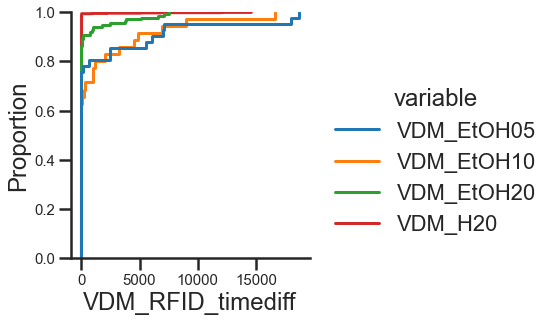

In [55]:
sns.displot(data=data_comb, x="VDM_RFID_timediff", kind="ecdf", hue='variable')

#plt.xlim(0, 60)
plt.show()

In [62]:
#remove any time diff greater than 1 sec
print(data_comb.shape)
data_comb_0 = data_comb[(data_comb['VDM_RFID_timediff']<3)]
print(data_comb_0.shape)

data_gbmean = data_comb_0.groupby(['Cage', 'IdRFID', 'day_count', 
                                   'Flavor', ])['value',].sum().reset_index()

data_gbmean.head()

(1170, 53)
(1063, 53)


,Cage,IdRFID,day_count,Flavor,value
0,1,041A5554CE,1,EtOH05,0.075
1,1,041A5554CE,1,EtOH20,0.162
2,1,041A5554CE,1,H20,0.286
3,1,041A5554CE,2,EtOH10,0.048
4,1,041A5554CE,2,EtOH20,0.621


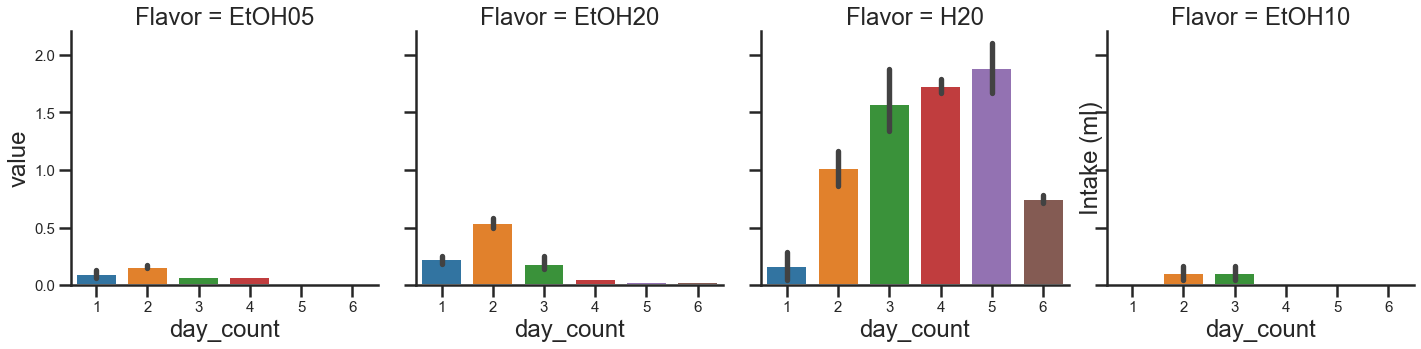

In [67]:
sns.catplot(x='day_count', y='value', data=data_gbmean,  kind='bar', 
            ci=68, height=5, aspect=1, col='Flavor')


plt.ylabel('Intake (ml)')

plt.show()

In [ ]:
data_comb_0.groupby(['Cage'])['IdRFID'].unique()

In [ ]:
data_ul1 = data_comb_0[data_comb_0['Flavor'] == 'EtOH05']
data_ul12 = data_ul1[data_ul1['day_count'] == 2]
#data_ul12 = data_ul1
colorCodes = ['C{}'.format(i) for i in range(8)]

param = 'sec_count_running'

data_1 = data_ul12[data_ul12['IdRFID'] == '041A5554E6'][param].values
data_2 = data_ul12[data_ul12['IdRFID'] == '041A555DA1'][param].values
data_3 = data_ul12[data_ul12['IdRFID'] == '041A555DEB'][param].values
data_4 = data_ul12[data_ul12['IdRFID'] == '041A555A4C'][param].values
data_5 = data_ul12[data_ul12['IdRFID'] == '041A555759'][param].values
data_6 = data_ul12[data_ul12['IdRFID'] == '041A55598E'][param].values
data_7 = data_ul12[data_ul12['IdRFID'] == '041A5552DC'][param].values
data_8 = data_ul12[data_ul12['IdRFID'] == '041A555BAC'][param].values

data_array = np.array([data_1, data_2, data_3, data_4, data_5,
                      data_6, data_7, data_8])

# Draw a spike raster plot
plt.figure(figsize=(70,20))
params = {'axes.labelsize': 75,
          'axes.titlesize': 75}
plt.rc('xtick', labelsize=60) 
plt.rc('ytick', labelsize=60) 
plt.rcParams.update(params)
plt.yticks([0,1,2,3,4,5,6,7,], 
           ['m', 'm', 'm', 'm', 'f', 'f', 'f', 'f',
            ])
plt.eventplot(data_array, color=colorCodes, linelengths = 0.3) 
plt.xlabel('Time (running second count)')
plt.ylabel('Sex')


plt.show()

In [ ]:
data_ul1 = data_comb[data_comb['Flavor'] == 'orange']
#data_ul12 = data_ul1[data_ul1['ld'] == 'light_day3']
data_ul12 = data_ul1
colorCodes = ['C{}'.format(i) for i in range(10)]

param = 'sec_count_running'

data_1 = data_ul12[data_ul12['IdRFID'] == '041A5556C7'][param].values
data_2 = data_ul12[data_ul12['IdRFID'] == '041A555759'][param].values
data_3 = data_ul12[data_ul12['IdRFID'] == '041A55598E'][param].values
data_4 = data_ul12[data_ul12['IdRFID'] == '041A5552DC'][param].values
data_5 = data_ul12[data_ul12['IdRFID'] == '041A555BAC'][param].values
data_6 = data_ul12[data_ul12['IdRFID'] == '041A5554E6'][param].values
data_7 = data_ul12[data_ul12['IdRFID'] == '041A555DA1'][param].values
data_8 = data_ul12[data_ul12['IdRFID'] == '041A555DEB'][param].values
data_9 = data_ul12[data_ul12['IdRFID'] == '041A555A4C'][param].values
data_10 = data_ul12[data_ul12['IdRFID'] == '041A555C38'][param].values

data_array = np.array([data_1, data_2, data_3, data_4, data_5,
                      data_6, data_7, data_8, data_9, data_10,
                      ])

# Draw a spike raster plot
plt.figure(figsize=(70,20))
params = {'axes.labelsize': 75,
          'axes.titlesize': 75}
plt.rc('xtick', labelsize=60) 
plt.rc('ytick', labelsize=60) 
plt.rcParams.update(params)
plt.yticks([0,1,2,3,4,5,6,7,8,9,], 
           ['f', 'f', 'f', 'f', 'f', 
            'm', 'm', 'm', 'm', 'm', 
            ])
plt.eventplot(data_array, color=colorCodes, linelengths = 0.3) 
plt.xlabel('Time (running second count)')
plt.ylabel('Sex')


plt.show()

In [ ]:
colorCodes = ['C{}'.format(i) for i in range(4)]
param = 'sec_count_running'

for IdRFID in data_comb['IdRFID'].unique():
    print(IdRFID)

    data_int = data_comb[data_comb['IdRFID']==IdRFID]
    data_1 = data_int[data_int['Flavor'] == 'cherry'][param].values
    data_2 = data_int[data_int['Flavor'] == 'orange'][param].values
    data_3 = data_int[data_int['Flavor'] == 'rasperry'][param].values
    data_4 = data_int[data_int['Flavor'] == 'grape'][param].values


    data_array = np.array([data_1, data_2, data_3, data_4])

    # Draw a spike raster plot
    plt.figure(figsize=(30,2))
    params = {'axes.labelsize': 50,'axes.titlesize': 50}
    plt.rc('xtick', labelsize=30) 
    plt.rc('ytick', labelsize=30) 
    plt.rcParams.update(params)
    plt.yticks([0,1,2,3],['cherry', 'orange', 'rasperry', 'grape'])
    plt.eventplot(data_array, color=colorCodes, linelengths = 0.3) 
    #plt.xlabel('Time (seconds)')
    #plt.ylabel('Activity')
        
    plt.show()

### Export data

In [ ]:
data_RFID_final.to_csv('data_RFID_final_1m_r2.csv')
data_comb.to_csv('data_comb_1m_r2.csv')